# Store Sales - Time Series Forecasting

## Goal

##### The goal of this analysis is to predict the sales for the thousands of product families sold at Favorita stores located in Ecuador. Predictions aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.

##### Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing.

## Dataset

##### We have datasets where we can get the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files like stores, oil, holidays events, transactions, etc. given to us which include supplementary information that may be useful in building your models.

## Liabraries

###### Import the required liabraries

In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt


# Importing the datasets and perform EDA 

### Transaction

1. From this data set we will get three major details. 
2. transaction gives the total transactions for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
3. store_nbr identifies the store at which the products are sold.

###### Import the data set and see a overall details

In [2]:
transac = pd.read_csv('transactions.csv')
print(transac.head(10))
transac.info()

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
5  2013-01-02          5          1903
6  2013-01-02          6          2143
7  2013-01-02          7          1874
8  2013-01-02          8          3250
9  2013-01-02          9          2940
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


###### From above we can see that date column data type is object. Lets make it to datetime format for further analysis.

In [3]:
transac['date'] = pd.to_datetime(transac['date'])

##### Lets analyse the transaction made each day. We can get a clear idea from a graphical view.

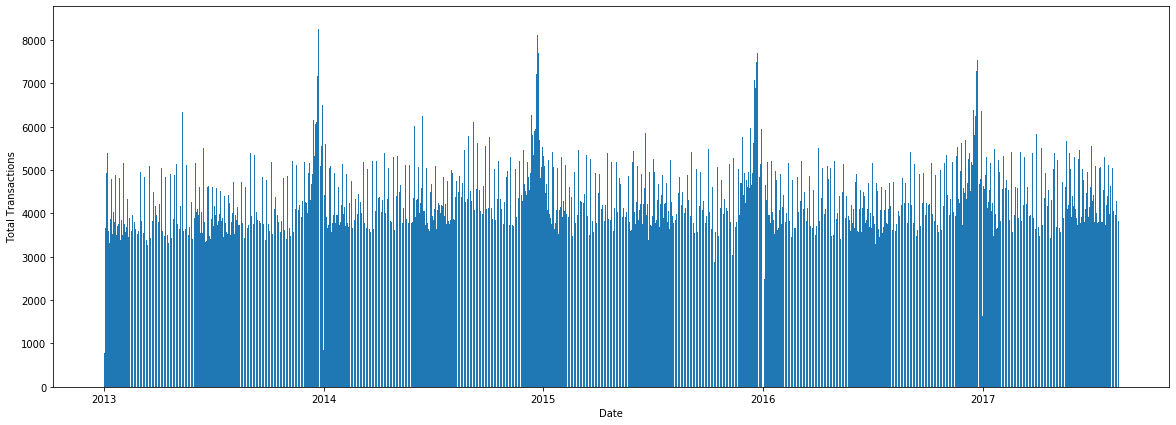

In [4]:
fig=plt.figure(figsize=(20,7))
plt.bar(transac['date'],transac['transactions'])
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.show()

##### From above we can clearly see that the transaction on decmber month of each year is too high. Specially from december 12th. That may be because of holidays and vacation season. 

##### Lets analyse the transaction made on each store. We can get a clear idea from a graphical view.

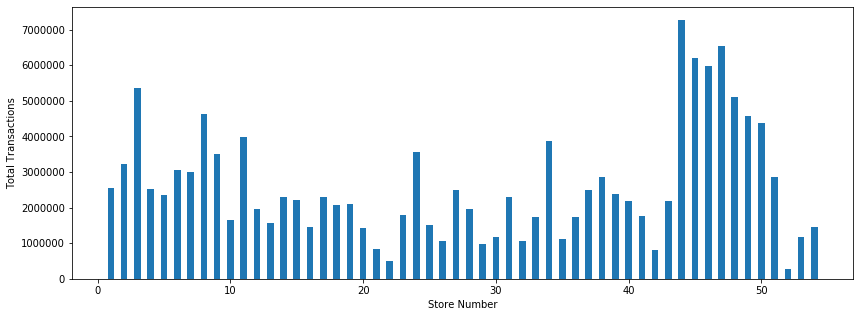

In [5]:
transac_store = transac[['store_nbr','transactions']].groupby('store_nbr').sum()
transac_store = transac_store.reset_index()
fig = plt.figure(figsize = (14, 5)) 
plt.bar(transac_store['store_nbr'], transac_store['transactions'],width=0.5)
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.show()

##### From above we can clearly see that store number 3, 8, 11, 44, 45, 46, 47, 48, 49 and 50 have lot of transactions i.e. sales is very good in these regions and we can focus on these.

### Stores

1. Store metadata, including city, state, type, and cluster.
2. cluster is a grouping of similar stores.


###### Import the data set and see a overall details

In [6]:
stores = pd.read_csv('stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


##### Lets see the number of stores available in each city.

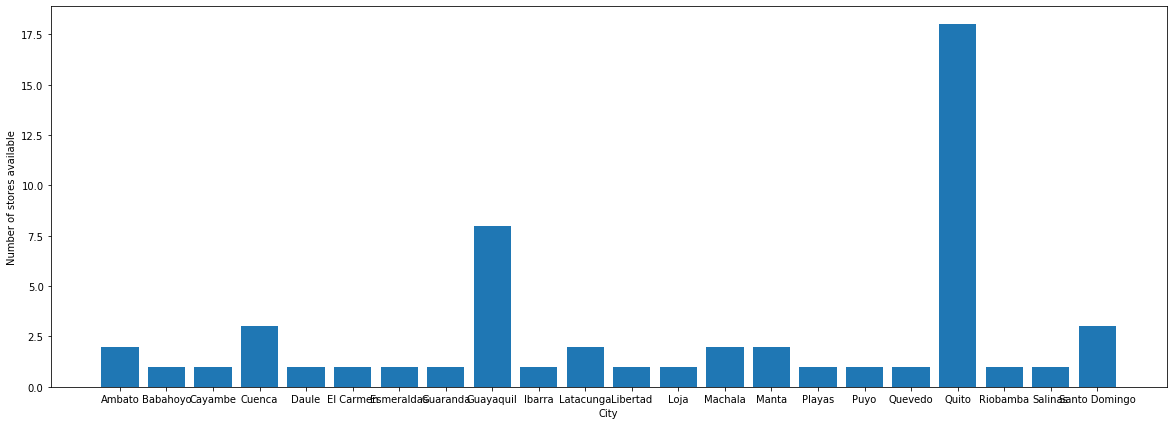

In [7]:
stores_city=stores[['city','store_nbr']].groupby('city').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(20,7))
plt.bar(stores_city['city'],stores_city['store_nbr'])
plt.xlabel('City')
plt.ylabel('Number of stores available')
plt.show()

##### Lets see the number of stores available in each clusters.

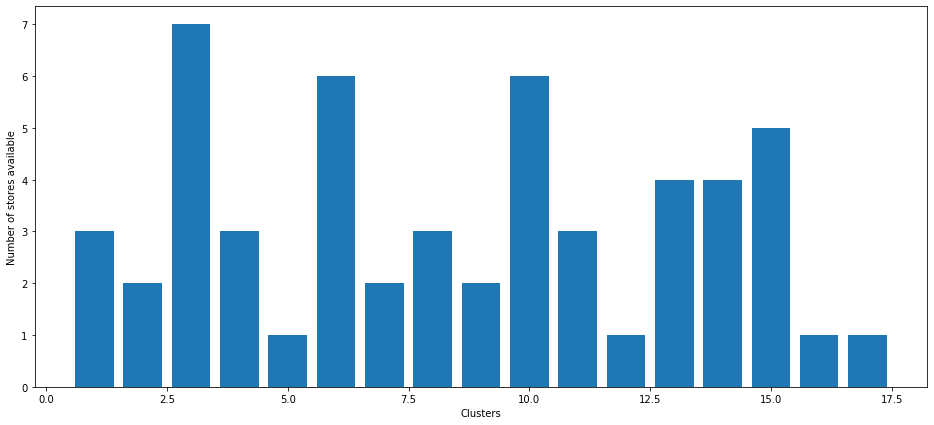

In [8]:
stores_city=stores[['cluster','store_nbr']].groupby('cluster').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(16,7))
plt.bar(stores_city['cluster'],stores_city['store_nbr'])
plt.xlabel('Clusters')
plt.ylabel('Number of stores available')
plt.show()

##### Lets see the number of stores available in each type of store.

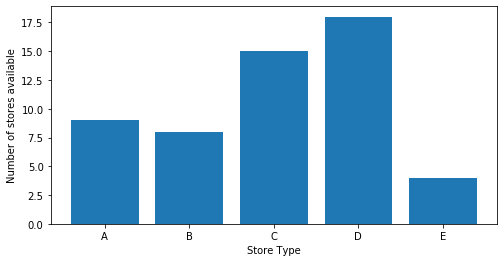

In [9]:
stores_city=stores[['type','store_nbr']].groupby('type').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(8,4))
plt.bar(stores_city['type'],stores_city['store_nbr'])
plt.xlabel('Store Type')
plt.ylabel('Number of stores available')
plt.show()

### Train Dataset

1. The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

2. store_nbr identifies the store at which the products are sold.

3. family identifies the type of product sold.

4. sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

5. onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

###### Import the data set and see a overall details

In [10]:
#importing the datsets
train=pd.read_csv('train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


###### From above we can see that date column data type is object. Lets make it to datetime format for further analysis.

In [12]:
train['date'] = pd.to_datetime(train['date'])

##### Lets analyse the total onpromotion i.e product family that were being promoted at a store

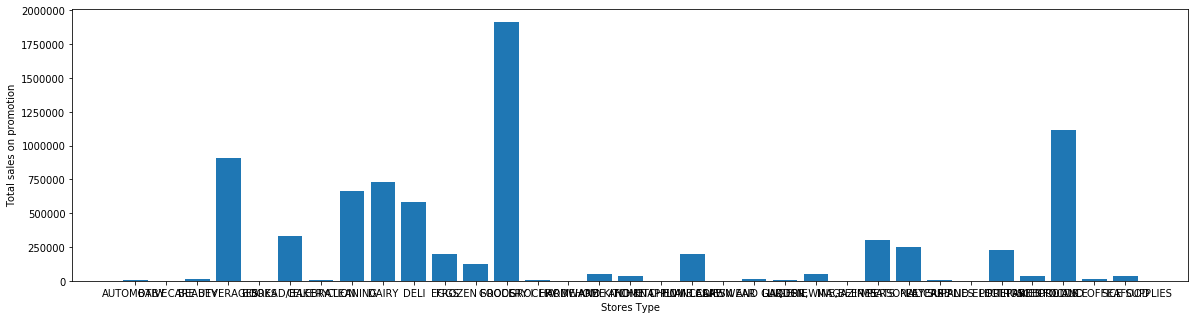

In [13]:
store_family=train[['family','onpromotion']].groupby('family').sum()
store_family=store_family.reset_index()
fig=plt.figure(figsize=(20,5))
plt.bar(store_family['family'],store_family['onpromotion'])
plt.xlabel('Stores Type')
plt.ylabel('Total sales on promotion')
plt.show()

##### Lets analyse the sales that gives the total sales for a product family from all the stores.

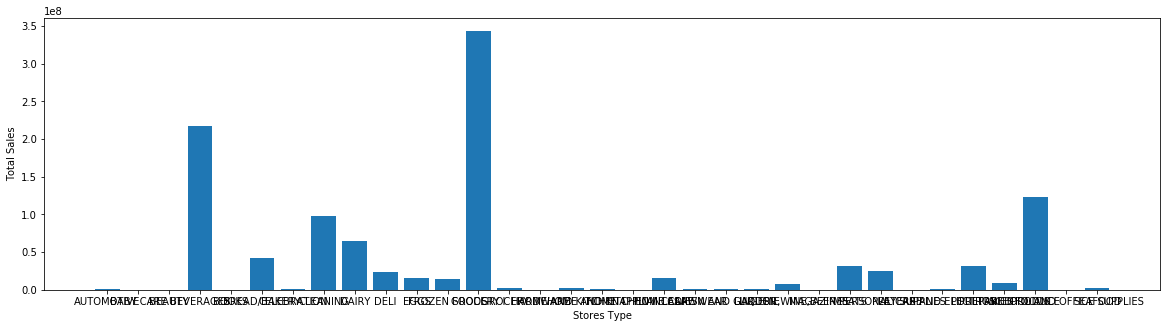

In [14]:
store_family=train[['family','sales']].groupby('family').sum()
store_family=store_family.reset_index()
fig=plt.figure(figsize=(20,5))
plt.bar(store_family['family'],store_family['sales'])
plt.xlabel('Stores Type')
plt.ylabel('Total Sales')
plt.show()

In [15]:
le = LabelEncoder()
train['family']=le.fit_transform(train['family'])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,0,0.0,0
1,1,2013-01-01,1,1,0.0,0
2,2,2013-01-01,1,2,0.0,0
3,3,2013-01-01,1,3,0.0,0
4,4,2013-01-01,1,4,0.0,0


### Test Dataset

1. The test data, having the same features as the training data. We have to predict the target sales for the dates in this file.
2. The dates in the test data are for the 15 days after the last date in the training data.

###### Import the data set and see a overall details

In [16]:
test=pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


###### From above we can see that date column data type is object. Lets make it to datetime format for further analysis.

In [18]:
test['date'] = pd.to_datetime(test['date'])

In [19]:
test['family']=le.fit_transform(test['family'])

In [20]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,0,0
1,3000889,2017-08-16,1,1,0
2,3000890,2017-08-16,1,2,2
3,3000891,2017-08-16,1,3,20
4,3000892,2017-08-16,1,4,0


##### We have analysed teh data set and got an overall idea for each data set. Now Its time to use Time Series Analysis (TSA).

## Time Series Analysis

Important Terms to understand for Time Series Analysis
A Time-Series is a sequence of data points collected at different timestamps. These are essentially successive measurements collected from the same data source at the same time interval. Further, we can use these chronologically gathered readings to monitor trends and changes over time. The time-series models can be univariate or multivariate. The univariate time series models are implemented when the dependent variable is a single time series, like room temperature measurement from a single sensor. On the other hand, a multivariate time series model can be used when there are multiple dependent variables, i.e., the output depends on more than one series. An example for the multivariate time-series model could be modelling the GDP, inflation, and unemployment together as these variables are linked to each other.

1. ***Stationary and Non-Stationary Time Series***

    Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up. A stationary time series id devoid of seasonal effects as well.


2. ***Trend***

    The trend shows a general direction of the time series data over a long period of time. A trend can be increasing(upward), decreasing(downward), or horizontal(stationary).


3. ***Seasonality***

    The seasonality component exhibits a trend that repeats with respect to timing, direction, and magnitude. Some examples include an increase in water consumption in summer due to hot weather conditions.


4. ***Cyclical Component***

    These are the trends with no set repetition over a particular period of time. A cycle refers to the period of ups and downs, booms and slums of a time series, mostly observed in business cycles. These cycles do not exhibit a seasonal variation but generally occur over a time period of 3 to 12 years depending on the nature of the time series.


5. ***Irregular Variation***

    These are the fluctuations in the time series data which become evident when trend and cyclical variations are removed. These variations are unpredictable, erratic, and may or may not be random.


6. ***ETS Decomposition***

    ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend and Seasonality.


7. ***Dependence***

    It refers to the association of two observations of the same variable at prior time periods.
    
    
8. ***Differencing***

    Differencing is used to make the series stationary and to control the auto-correlations. There may be some cases in time series analyses where we do not require differencing and over-differenced series can produce wrong estimates.


9. ***Specification***

    It may involve the testing of the linear or non-linear relationships of dependent variables by using time series models such as ARIMA models.


##### Lets check the stationarity of our data set.
##### Stationary

A stationary time series has statistical properties or moments (e.g., mean and variance) that do not vary in time. Stationarity, then, is the status of a stationary time series. Conversely, nonstationarity is the status of a time series whose statistical properties are changing through time.

Data points are often non-stationary or have means, variances, and covariances that change over time. Non-stationary behaviors can be trends, cycles, random walks, or combinations of the three. Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted.

###### How to test for stationarity?
The stationarity of a series can be established by looking at the plot of the series like we did earlier.

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

Nevertheless, you need a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.

There are multiple implementations of Unit Root tests like:

    Augmented Dickey Fuller test (ADH Test)
    Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
    Philips Perron test (PP Test)
    
We will try ***Augmented Dickey Fuller (ADF)*** method to check the stationarity of our dataset. This is the most commonly used test method, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis


Lets create a function that will test the stationarity of dataset and we can use this frequently.

In [21]:
def adf_test(series):
    result=adfuller(series)
    print('p value after test is ',result[1])
    if result[1] > 0.05:
        print('Null Hypothesis rejected and data set is not a stationary')
    else:
        print('Null Hypothesis can not be rejected and data set is a stationary')

In [22]:
sales_train=train[['date','sales']].groupby('date').sum()
adf_test(sales_train['sales'])

p value after test is  0.08969592175787466
Null Hypothesis rejected and data set is not a stationary


From above we can crealy see that our data set is not a stationary data set.


            
            

***How to make a time series stationary?***
   
We can apply some sort of transformation to make the time-series stationary. These transformation may include:

    Differencing the Series (once or more)
    Take the log of the series
    Take the nth root of the series
    Combination of the above
    
    
Let's use differentiating concept to make our data set as stationary

In [23]:
sales_train['1shifted sales'] = sales_train['sales'] - sales_train ['sales'].shift(1)
print(sales_train.head())
sales_train = sales_train.dropna()
adf_test(sales_train['1shifted sales'])

                    sales  1shifted sales
date                                     
2013-01-01    2511.618999             NaN
2013-01-02  496092.417944   493580.798945
2013-01-03  361461.231124  -134631.186820
2013-01-04  354459.677093    -7001.554031
2013-01-05  477350.121229   122890.444136
p value after test is  4.573768417346115e-21
Null Hypothesis can not be rejected and data set is a stationary


After applying differentiating method we can get our stationary data and now we are ready for further evaluation.

##### Autocorrelation and Partial Autocorrelation 

The term autocorrelation refers to the degree of similarity between A) a given time series, and B) a lagged version of itself, over C) successive time intervals. In other words, autocorrelation is intended to measure the relationship between a variable's present value and any past values that you may have access to.

When regression is performed on time series data, the errors may not be independent. Often errors are autocorrelated; that is, each error is correlated with the error immediately before it. Autocorrelation is also a symptom of systematic lack of fit. The DW option provides the Durbin-Watson d statistic to test that the autocorrelation is zero: d = \frac{ \sum_{i=2}^n (ei - e{i-1})^2}{\sum_{i=1}^n e_i^2} The value of d is close to 2 if the errors are uncorrelated. The distribution of d is reported by Durbin and Watson (1951). Tables of the distribution are found in most econometrics textbooks, such as Johnston (1972) and Pindyck and Rubinfeld (1981).

The sample autocorrelation estimate is displayed after the Durbin-Watson statistic. The sample is computed as

r = \frac{\sum_{i=2}^n ei e{i-1}}{\sum_{i=1}^n e_i^2} This autocorrelation of the residuals may not be a very good estimate of the autocorrelation of the true errors, especially if there are few observations and the independent variables have certain patterns. If there are missing observations in the regression, these measures are computed as though the missing observations did not exist.

Positive autocorrelation of the errors generally tends to make the estimate of the error variance too small, so confidence intervals are too narrow and true null hypotheses are rejected with a higher probability than the stated significance level. Negative autocorrelation of the errors generally tends to make the estimate of the error variance too large, so confidence intervals are too wide and the power of significance tests is reduced. With either positive or negative autocorrelation, least-squares parameter estimates are usually not as efficient as generalized least-squares parameter estimates.

Autocorrelation is the correlation between two observations at different points in a time series. For example, values that are separated by an interval might have a strong positive or negative correlation. When these correlations are present, they indicate that past values influence the current value. Analysts use the autocorrelation and partial autocorrelation functions to understand the properties of time series data, fit the appropriate models, and make forecasts.

In this post, I cover both the autocorrelation function and partial autocorrelation function. You’ll learn about the differences between these functions and what they can tell you about your data. In later posts, I’ll show you how to incorporate this information in regression models of time series data and other time-series analyses.

***Autocorrelation and Partial Autocorrelation Basics***

    Autocorrelation is the correlation between two values in a time series. In other words, the time series data correlate with themselves—hence, the name. We talk about these correlations using the term “lags.” Analysts record time-series data by measuring a characteristic at evenly spaced intervals—such as daily, monthly, or yearly. The number of intervals between the two observations is the lag. For example, the lag between the current and previous observation is one. If you go back one more interval, the lag is two, and so on.
    
    In mathematical terms, the observations at yt and yt–k are separated by k time units. K is the lag. This lag can be days, quarters, or years depending on the nature of the data. When k=1, you’re assessing adjacent observations. For each lag, there is a correlation.

***Autocorrelation Function (ACF)***

    Use the autocorrelation function (ACF) to identify which lags have significant correlations, understand the patterns and properties of the time series, and then use that information to model the time series data. From the ACF, you can assess the randomness and stationarity of a time series. You can also determine whether trends and seasonal patterns are present.
    
    In an ACF plot, each bar represents the size and direction of the correlation. Bars that extend across the red line are statistically significant.

***Partial Autocorrelation Function (PACF)***
    
    The partial autocorrelation function is similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain. For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between those two observations after partialling out the intervening correlations.
    
    As you saw, the autocorrelation function helps assess the properties of a time series. In contrast, the partial autocorrelation function (PACF) is more useful during the specification process for an autoregressive model. Analysts use partial autocorrelation plots to specify regression models with time series data and Auto Regressive Integrated Moving Average (ARIMA) models. I’ll focus on that aspect in posts about those methods.

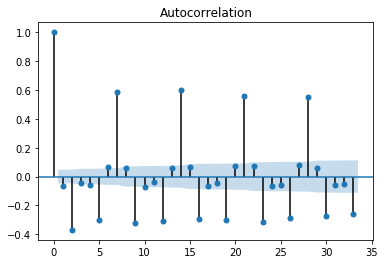

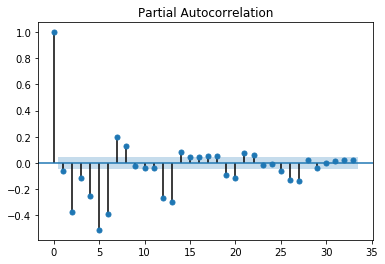

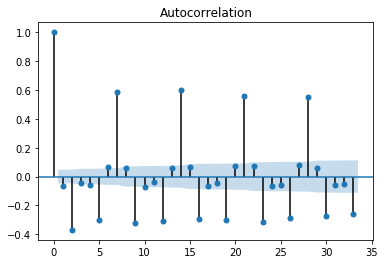

In [24]:
plot_pacf(sales_train['1shifted sales'])
plot_acf(sales_train['1shifted sales'])

#### Seasonality

A seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

Yearly : Example - Black Friday and chrismas Sales
Monthly : Example - We may find big sales on first week of the month as slalry is paid that time


***How to test for seasonality of a time series?***

The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

    Hour of day
    Day of month
    Weekly
    Monthly
    Yearly

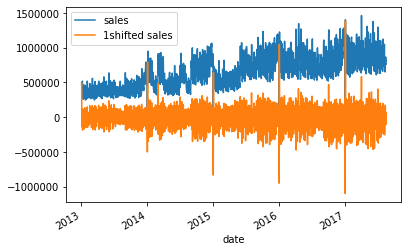

In [25]:
sales_train.plot()

From above we can clearly see the seasonality in our dataset. At the end of each year we can clearly see the increase in sales and some decrease in sales at mid of year.

### ARIMA Model
    ARIMA Model stands for Auto-Regressive Integrated Moving Average. It is used to predict the future values of a time series using its past values and forecast errors. The below diagram shows the components of an ARIMA model:



***Auto Regressive Model¶***
       
      Auto-Regressive models predict future behavior using past behavior where there is some correlation between past and future data. The formula below represents the autoregressive model. It is a modified version of the slope formula with the target value being expressed as the sum of the intercept, the product of a coefficient and the previous output, and an error correction term.



***Moving Average***

    Moving Average is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time. You can get it by taking different subsets of your data and finding their respective averages.

    You first consider a bunch of data points and take their average. You then find the next average by removing the first value of the data and including the next value of the series.



***Integration***

    Integration is the difference between present and previous observations. It is used to make the time series stationary.

    Each of these values acts as a parameter for our ARIMA model. Instead of representing the ARIMA model by these various operators and models, you use parameters to represent them. These parameters are:

    p: Previous lagged values for each time point. Derived from the Auto-Regressive Model.
    q: Previous lagged values for the error term. Derived from the Moving Average.
    d: Number of times data is differenced to make it stationary. It is the number of times it performs integration.

Let's start our ARIMA model with proper data.

In [26]:
sales_train['1shifted sales'] = sales_train['1shifted sales'].astype('float64')

In [27]:
model_arima = ARIMA (sales_train['sales'],order = (0,1,0))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()   

C:\Users\SarojRakesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\SarojRakesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has b

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                 1682
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -22536.380
Method:                           css   S.D. of innovations         159471.893
Date:                Mon, 12 Sep 2022   AIC                          45076.761
Time:                        21:56:13   BIC                          45087.616
Sample:                             1   HQIC                         45080.782
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.4837   3888.402      0.041      0.967   -7462.644    7779.611
==============================================================================
"""

##### Residuals
The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values:



Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Let's plot residuals for our ARIMA model

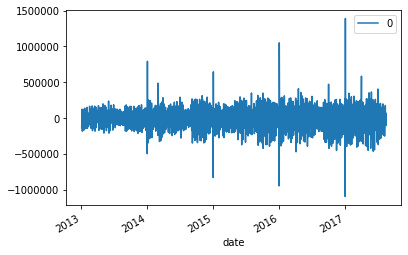

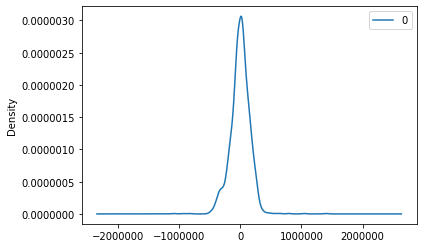

                  0
count  1.682000e+03
mean   5.466701e-13
std    1.595193e+05
min   -1.097089e+06
25%   -7.984066e+04
50%    9.558020e+03
75%    9.535378e+04
max    1.390065e+06


In [28]:
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

We have created our model and now its time to predict the data.

In [29]:
pred_arima=model_arima_fit.predict(start=datetime(2017,6,1),end=datetime(2017,7,1))
pred_arima

date
2017-06-01    158.483661
2017-06-02    158.483661
2017-06-03    158.483661
2017-06-04    158.483661
2017-06-05    158.483661
2017-06-06    158.483661
2017-06-07    158.483661
2017-06-08    158.483661
2017-06-09    158.483661
2017-06-10    158.483661
2017-06-11    158.483661
2017-06-12    158.483661
2017-06-13    158.483661
2017-06-14    158.483661
2017-06-15    158.483661
2017-06-16    158.483661
2017-06-17    158.483661
2017-06-18    158.483661
2017-06-19    158.483661
2017-06-20    158.483661
2017-06-21    158.483661
2017-06-22    158.483661
2017-06-23    158.483661
2017-06-24    158.483661
2017-06-25    158.483661
2017-06-26    158.483661
2017-06-27    158.483661
2017-06-28    158.483661
2017-06-29    158.483661
2017-06-30    158.483661
2017-07-01    158.483661
dtype: float64

Previously we discussed the seasonality in our data set. Because of that seasonality our ARIMA model may not work properly and for this we have a better model concept called as ***SARIMAX***

### SARIMAX

    Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the ARIMA class of models. Intuitively, ARIMA models compose 2 parts: the autoregressive term (AR) and the moving-average term (MA). The former views the value at one time just as a weighted sum of past values. The latter model that same value also as a weighted sum but of past residuals (confer. time series decomposition). There is also an integrated term (I) to difference the time series (we will discuss this further below). Since this is such a rich topic with a lot of math involved, we strongly recommend you to do further readings to have a better understanding.

    Overall, ARIMA is a very decent type of models. However, the problem with this vanilla version is that it cannot handle seasonality — a big weakness. Comes SARIMA — the predecessor of SARIMAX. One shorthand notation for SARIMA models is:

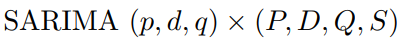

    where 
    p = non-seasonal autoregressive (AR) order
    d = non-seasonal differencing
    q= non-seasonal moving average (MA) order
    P = seasonal AR order, D = seasonal differencing 
    Q = seasonal MA order
    S = length of repeating seasonal pattern. 
    
    We will use this notation from now on. By adding those seasonal AR and seasonal MA components, SARIMA solves the seasonality problem.

In [30]:
#SARIMAX Model
model_SARIMA=SARIMAX(sales_train['sales'],order=(3,0,6),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

C:\Users\SarojRakesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\SarojRakesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\SarojRakesh\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1683
Model:             SARIMAX(3, 0, 6)x(0, 1, [], 12)   Log Likelihood              -22435.789
Date:                             Mon, 12 Sep 2022   AIC                          44891.578
Time:                                     21:56:32   BIC                          44945.789
Sample:                                          0   HQIC                         44911.664
                                            - 1683                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5353      0.019     28.375      0.000       0.498       0.572
ar.L2         -0.5492      0.014    -39.127      0.000      -0.577      -0.522
ar.L3          0.9171      0.018     50.120      0.000       0.881       0.953
ma.L1          0.3193      0.021     15.507      0.000       0.279       0.360
ma.L2          0.8159      0.018     46.605      0.000       0.782       0.850
ma.L3         -0.3706      0.019    -19.609      0.000      -0.408      -0.334
ma.L4         -0.6162      0.016    -38.068      0.000      -0.648      -0.585
ma.L5         -0.6855      0.015    -46.418      0.000      -0.714      -0.657
ma.L6         -0.4331      0.022    -19.267      0.000      -0.477      -0.389
sigma2      3.587e+10   3.48e-13   1.03e+23      0.000    3.59e+10    3.59e+10
===================================================================================
Ljung-Box (L1) (Q):                  15.13   Jarque-Bera (JB):              5628.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+38. Standard errors may be unstable.
"""

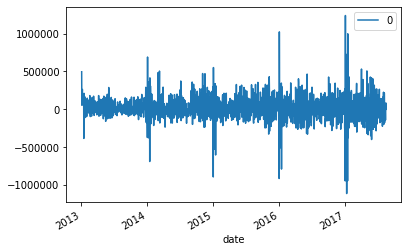

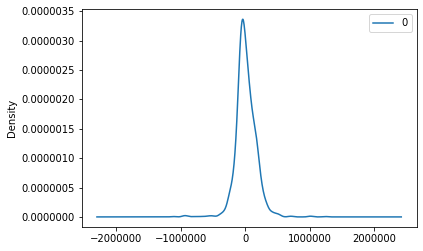

                  0
count  1.683000e+03
mean   1.394634e+04
std    1.594050e+05
min   -1.116295e+06
25%   -7.211001e+04
50%   -2.856440e+03
75%    9.829166e+04
max    1.240619e+06


In [31]:
residuals = pd.DataFrame(model_SARIMA_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

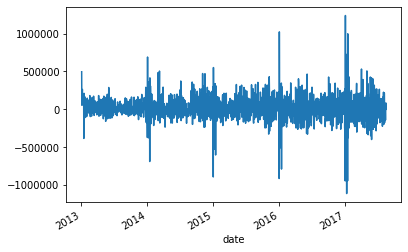

In [32]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2017,6,1),end=datetime(2017,7,1))
residuals=sales_train['sales']-pred_Sarima
model_SARIMA_fit.resid.plot()

Let's predict the sales with the help of our SARIMAX model and plot residuals.

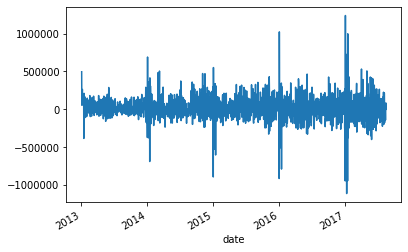

In [33]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2017,8,10),end=datetime(2017,8,13))
residuals=sales_train['sales']-pred_Sarima
model_SARIMA_fit.resid.plot()

We have checked both the ARIMAX and SARIMAX model. Let's analyse the pros and cons for both of the model.

### Pros and Cons
***Pros of ARIMA & SARIMA***
    
    1. Easy to understand and interpret: The one thing that your fellow teammates and colleagues would appreciate is the simplicity and interpretability of the models. Focusing on both of these things while also maintaining the quality of the results will help with presentations with the stakeholders.
    
    2. Limited variables: There are fewer hyperparameters so the config file will be easily maintainable if the model goes into production.


***Cons of ARIMA & SARIMA***

    1. Exponential time complexity: When the value of p and q increases there are equally more coefficients to fit hence increasing the time complexity manifold if p and q are high. This makes both of these algorithms hard to put into production and makes Data Scientists look into Prophet and other algorithms. Then again, it depends on the complexity of the dataset too.
    
    2. Complex data: There can be a possibility where your data is too complex and there is no optimal solution for p and q. Although highly unlikely that ARIMA and SARIMA would fail but if this occurs then unfortunately you may have to look elsewhere.
    
    3. Amount of data needed: Both the algorithms require considerable data to work on, especially if the data is seasonal. For example, using three years of historical demand is likely not to be enough (Short Life-Cycle Products) for a good forecast.

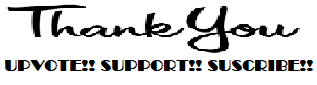